# 180 Days BP Data
* GAN用の180日間分のデータを用意する: SBP,DBP,PUL (3 dim) 

In [1]:
import mojimoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Reading Data

In [2]:
df_bp = pd.read_csv(
    r'/home/hiroshi_koshimizu/work/dataset/P005_BpData_180424.csv', 
    encoding = 'shift-jis', 
    engine = 'python',
    index_col = 'Unnamed: 0'
)

## Convert String

In [3]:
df_bp['Name'] = df_bp['Name'].map(lambda string: mojimoji.zen_to_han(string))
df_bp['Name'] = df_bp['Name'].map(lambda string: string.replace('･', '/'))
df_bp['Date'] = pd.DatetimeIndex(df_bp['Date'])
df_bp['Month'] = df_bp['Date'].map(lambda date:date.month)
df_bp['Week'] = df_bp['Date'].map(lambda date:date.week)
df_bp['Time'] = df_bp['Time'].map(lambda x :pd.to_datetime(x).time())

## Delete useless colomns

In [4]:
df_bp.columns

Index(['Name', 'Birth', 'Age', 'Sex', 'Date', 'Time', 'Type', 'SBP', 'DBP',
       'PUL', 'Fit', 'Move', 'Temp', 'Irr.PUL', 'Check', 'Meas_Time', 'Month',
       'Week'],
      dtype='object')

In [5]:
df_bp = df_bp.drop(['Birth', 'Age', 'Sex', 'Fit', 'Move', 'Check', 'Irr.PUL', 'Meas_Time', 'Week', 'Month'], axis = 1)

## Extract Type

In [6]:
#血圧情報の時間単位のME判定
def ml_bpdata_mejudge(dataframe, start = [[],[]], end = [[],[]]):
    import datetime
    tmp = dataframe.copy()
    tmp['Type'] = None
    
    #Type Mを振りなおし
    flag = np.logical_and(
        tmp['Time'] >= datetime.time(start[0][0],start[0][1], start[0][2]),
        tmp['Time'] < datetime.time(end[0][0],end[0][1], end[0][2])
    )
    tmp.loc[flag, 'Type'] = 'M'
    
    #Type Eを振り直し
    flag = np.logical_or(
        tmp['Time'] >= datetime.time(start[1][0],start[1][1], start[1][2]),
        tmp['Time'] < datetime.time(end[1][0],end[1][1], end[1][2])
    )
    tmp.loc[flag, 'Type'] = 'E'
    
    tmp = tmp[np.logical_or(tmp['Type'] == 'M', tmp['Type'] == 'E')]
    
    return tmp.reset_index(drop = True)
#晩測定の時間シフト
def ml_bpdata_eshift(dataframe, e_end_time):
    import datetime
    tmp = dataframe.copy()
    flag = tmp['Time'] < datetime.time(e_end_time[0],e_end_time[1],e_end_time[2])
    tmp.loc[flag,'Date'] = tmp.loc[flag, 'Date'] - datetime.timedelta(days = 1)
    tmp['Time'] = tmp['Time'].map(lambda x:x.hour)
    tmp_time = tmp.loc[tmp['Time'] < 2, 'Time'].copy()
    #24時間異常表現
    tmp.loc[tmp['Time'] < 2, 'Time'] = tmp_time + 24
    return tmp.reset_index(drop = True)

In [7]:
test_tmp = ml_bpdata_mejudge(df_bp, start = [[4,0,0],[18,0,0]], end = [[12,0,0],[2,0,0]])
test_tmp = ml_bpdata_eshift(test_tmp, e_end_time = [2,0,0])

In [8]:
#MEデータのみする
test_e = test_tmp[test_tmp['Type']== 'E']
test_m = test_tmp[test_tmp['Type']== 'M']

In [9]:
#MEデータ抽出物
def gen_dayme_data(df, name, me_type = 'M' ):
    tmp = df[df['Name'] == name].copy().reset_index(drop = True)
    if me_type == 'M':
        df_list = map( lambda x: tmp[tmp['Date']==x][:2], tmp['Date'].unique() )
    else:
        df_list = map( lambda x: tmp[tmp['Date']==x][-2:], tmp['Date'].unique())
    return pd.concat(df_list, axis = 0)

In [10]:
#晩抽出
test_e = pd.concat(
    list(
        map( 
            lambda x : gen_dayme_data(test_e, x, me_type = 'E'), 
            test_e['Name'].unique() 
        )
    ), 
    axis = 0
)

#朝抽出
test_m = pd.concat(
    list(
        map(
            lambda x : gen_dayme_data(test_m, x, me_type = 'M'),
            test_m['Name'].unique() 
        )
    ), 
    axis = 0
)

In [11]:
test_all = pd.concat([test_e, test_m], axis = 0).drop(['Time', 'Temp'], axis = 1)

## Group by

In [12]:
test_all = pd.pivot_table(
    data = test_all, 
    index = ['Name','Date'],
    columns = ['Type'],
    aggfunc = np.mean
)
test_all.columns = ['_'.join(col_i) for col_i in test_all.columns]
test_all.reset_index(inplace = True)

In [13]:
def make_fill(df, name):
    tmp = df[df['Name'].isin([name])].copy()
    tmp = tmp.set_index('Date')
    tmp = tmp.resample('D').mean().fillna(method='ffill')
    tmp['Name'] = name
    return tmp

In [14]:
test_all = pd.concat(
    list(
        map(lambda x: make_fill(test_all, x), test_all['Name'].unique())
    )
).reset_index().dropna()

In [15]:
test_all[0:]

,Date,DBP_E,DBP_M,PUL_E,PUL_M,SBP_E,SBP_M,Name
1,2015-01-28,76.5,85.0,71.5,69.0,130.0,155.5,N/Predict 0001
2,2015-01-29,86.5,90.5,71.0,74.0,154.0,159.0,N/Predict 0001
3,2015-01-30,73.0,75.0,65.5,67.0,123.0,122.0,N/Predict 0001
4,2015-01-31,77.0,75.0,72.0,67.0,131.5,122.0,N/Predict 0001
5,2015-02-01,77.5,79.0,76.0,71.5,133.5,138.0,N/Predict 0001
6,2015-02-02,68.5,86.5,75.0,69.5,116.5,154.5,N/Predict 0001
7,2015-02-03,79.0,75.5,73.0,77.5,137.5,142.5,N/Predict 0001
8,2015-02-04,71.5,86.0,73.0,71.0,130.5,161.0,N/Predict 0001
9,2015-02-05,80.0,82.0,70.0,68.5,155.5,148.0,N/Predict 0001
10,2015-02-06,74.0,87.0,78.0,65.0,135.0,156.5,N/Predict 0001


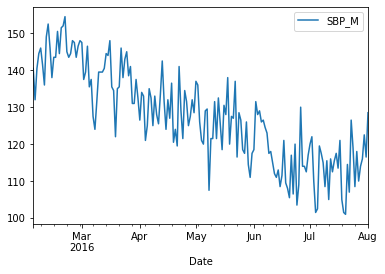

In [16]:
test_all[test_all['Name'].isin(['N/Predict 0098'])][260:260+180].plot(
    x = 'Date', 
    y = [
        'SBP_M', 
    #    'DBP_M', 
    #    'PUL_M'
    ],
)

In [17]:
day_param = 180
#df_bp_gr = test_all.groupby(by = ['Name','Date'], as_index = False, observed = True).mean()
df_bp_gr = test_all.set_index('Date')
#df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
#df_bp_gr = df_bp_gr.reset_index(drop = True)

In [18]:
def get_timeseries(df, name, day_param, interval):
    tmp = df[df['Name'].isin([name])].resample('1D').mean().copy()
    array = []
    for inter_i in range( len(tmp) // interval ):
        array.append(tmp[inter_i*interval:day_param+inter_i*interval].T.values.flatten().tolist() + [name])
    return pd.DataFrame(array)

In [19]:
target_df = pd.concat(
    list(
        map(
            lambda x: get_timeseries(df_bp_gr, x, day_param, 14),
            df_bp_gr['Name'].unique()
        )
    )
)

In [20]:
columns = []
for col_name in df_bp_gr.columns[0:-1]:
    columns.extend([col_name + str(i+1) for i in range(day_param)])
target_df.columns = columns + ['Name']

In [21]:
target_df.dropna(inplace = True)

In [22]:
target_df.shape

(15370, 1081)

In [23]:
target_df

,DBP_E1,DBP_E2,DBP_E3,DBP_E4,DBP_E5,DBP_E6,DBP_E7,DBP_E8,DBP_E9,DBP_E10,...,SBP_M172,SBP_M173,SBP_M174,SBP_M175,SBP_M176,SBP_M177,SBP_M178,SBP_M179,SBP_M180,Name
0,76.5,86.5,73.0,77.0,77.5,68.5,79.0,71.5,80.0,74.0,...,124.5,138.0,126.5,132.5,137.5,131.0,126.5,134.5,141.5,N/Predict 0001
1,77.0,73.5,80.0,72.5,71.5,76.0,71.5,75.0,70.5,74.0,...,130.0,130.0,148.5,135,146.0,144.0,125.5,125.5,135.5,N/Predict 0001
2,78.0,78.5,78.5,76.5,79.0,82.0,72.0,78.5,78.0,72.0,...,145.0,144.5,147.5,128.5,155.0,133.0,134.5,138.5,139.0,N/Predict 0001
3,73.5,80.0,78.0,78.0,79.0,81.5,72.5,74.0,78.0,78.5,...,135.0,135.0,131.5,132.5,136.0,123.0,131.0,134.5,115.0,N/Predict 0001
4,70.0,78.0,75.0,76.0,71.5,75.5,73.0,73.0,73.0,73.0,...,138.0,151.5,146.0,136,133.5,119.0,133.5,140.0,150.0,N/Predict 0001
5,73.0,73.0,77.5,74.0,76.0,76.5,78.5,82.0,71.0,75.5,...,133.5,125.5,134.5,143,150.5,150.5,123.5,129.5,132.0,N/Predict 0001
6,75.5,75.5,74.0,74.0,78.0,74.5,73.5,73.5,73.0,71.0,...,149.0,144.0,146.5,148.5,151.5,144.0,139.0,132.5,140.0,N/Predict 0001
7,71.0,76.5,75.5,79.5,71.0,72.5,75.0,74.0,70.5,70.5,...,149.0,147.5,157.5,136,129.5,138.0,132.5,144.0,147.0,N/Predict 0001
8,72.5,76.5,73.5,73.0,73.5,78.5,82.5,77.0,75.0,74.5,...,131.5,125.5,127.5,119,126.5,138.0,142.5,127.5,132.0,N/Predict 0001
9,71.5,68.5,73.5,79.5,76.5,75.0,72.5,71.0,68.5,71.5,...,145.0,132.0,142.5,134.5,144.0,151.5,121.0,130.5,122.5,N/Predict 0001


## Determine labels

In [24]:
target_df['msbp'] = target_df.loc[:, 'SBP_M1':'SBP_M180'].mean(axis = 1)
target_df['mdbp'] = target_df.loc[:, 'DBP_M1':'DBP_M180'].mean(axis = 1)
target_df.reset_index(inplace = True, drop = True)

In [30]:
target_df['labels'] = int(0)
s_hyflag = target_df['msbp'] >= 135
target_df.loc[s_hyflag == True, 'labels'] = int(1)

d_hyflag = target_df['mdbp'] >= 85
target_df.loc[d_hyflag == True, 'labels'] = int(2)

sd_hyflag = np.logical_and( target_df['msbp'] >= 135, target_df['mdbp'] >= 85)
target_df.loc[sd_hyflag == True, 'labels'] = int(3)

#sd_hyflag = np.logical_and( target_df['msbp'] >= 150, target_df['mdbp'] >= 100)
#target_df.loc[sd_hyflag == True, 'labels'] = int(4)

In [31]:
target_df_arr = target_df.iloc[:, :-4].values.reshape(
    len(target_df), 
    len(target_df.iloc[:, :-4].columns) // day_param, 
    day_param
).transpose(0,2,1)

In [32]:
target_df_arr.shape

(15370, 180, 6)

## Wirte Data

In [33]:
np.savez('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_180_slide.npz',x = target_df_arr, y = target_df['labels'].values)

In [34]:
target_df['labels'].value_counts()

0    10280
1     1987
2     1642
3     1461
Name: labels, dtype: int64

In [35]:
target_df_arr

array([[[76.5, 85.0, 71.5, 69.0, 130.0, 155.5],
        [86.5, 90.5, 71.0, 74.0, 154.0, 159.0],
        [73.0, 75.0, 65.5, 67.0, 123.0, 122.0],
        ...,
        [69.0, 75.5, 66.5, 70.5, 116.5, 126.5],
        [69.0, 71.5, 66.5, 69.5, 116.5, 134.5],
        [73.5, 77.5, 64.0, 70.5, 136.0, 141.5]],

       [[77.0, 84.0, 73.5, 74.0, 130.0, 153.5],
        [73.5, 79.5, 70.5, 71.0, 118.0, 135.0],
        [80.0, 79.5, 73.0, 68.0, 135.0, 130.0],
        ...,
        [76.0, 75.0, 66.5, 63.5, 128.0, 125.5],
        [74.5, 76.5, 65.5, 67.0, 129.0, 125.5],
        [83.0, 78.0, 68.5, 61.5, 143.0, 135.5]],

       [[78.0, 77.5, 69.0, 65.5, 139.0, 144.5],
        [78.5, 80.0, 66.0, 65.5, 138.5, 152.5],
        [78.5, 89.0, 71.0, 67.5, 145.5, 173.0],
        ...,
        [73.0, 79.0, 67.0, 66.0, 124.0, 134.5],
        [73.0, 78.5, 67.0, 62.5, 124.0, 138.5],
        [79.0, 78.5, 65.0, 66.0, 139.0, 139.0]],

       ...,

       [[90.5, 94.5, 80.5, 70.0, 139.5, 156.5],
        [81.0, 85.0, 83.0, 74.

In [36]:
import numpy as np
data = np.load('../../inputs/bp_data_180_slide.npz', allow_pickle = True)

In [37]:
data['x'].shape

(15370, 180, 6)